In [60]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

In [61]:
import pickle

posts = []
with open ('processed_posts.pkl', 'rb') as fp:
    posts = pickle.load(fp)

In [62]:
tokenized_posts = []

for post in posts:
    user = []
    for sentence in post:
        user += sentence.split(" ")
        
    tokenized_posts.append(user)

In [63]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [64]:
from collections import Counter

In [65]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [66]:
dictionary = list(zip(*dictionary))[0]

In [67]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [68]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [69]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

def to_one_hot(arr):
    one_hot_types = []

    for label in arr:
        bin_type = []

        if (label[0] == 'I'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[1] == 'N'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[2] == 'T'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[3] == 'J'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        one_hot_types.append(bin_type)
        
    return one_hot_types
    

In [70]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x = vectorize_sequences(x_vals)
y = np.asarray(to_one_hot(labels)).astype('float32')

In [71]:
indices = np.arange(x.shape[0])
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [72]:
x_test = x[:1000]
y_test = y[:1000]

x_train = x[1000:]
y_train = y[1000:]

x_val = x_train[:500]
y_val = y_train[:500]

partial_x_train = x_train[500:]
partial_y_train = y_train[500:]

In [73]:
#These are for full label prediction
class_weights = [{0:1, 1:8}, {0:1, 1:6.24}, {0:1, 1:1.18}, {0:1, 1:0.65}]

In [74]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras.regularizers import l2
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(4, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [75]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.total_accuracy = []
        self.i_accuracy = []
        self.e_accuracy = []
    
    def ie_real_acc(self, prediction):
        y_true = self.validation_data[1]
        i_acc = 0
        i_total = 0
        e_acc = 0
        e_total = 0
        for i in range(0, len(prediction)):
            if (y_true[i].round() == 0):
                if (prediction[i].round() == y_true[i]):
                    i_acc += 1
                i_total += 1
            else:
                if (prediction[i].round() == y_true[i]):
                    e_acc += 1
                e_total += 1
        return (i_acc/i_total), (e_acc/e_total)

    def on_epoch_end(self, epoch, logs={}):
        x_val = self.validation_data[0]
        y_pred = self.model.predict(x_val)
        i_real_acc, e_real_acc = self.ie_real_acc(y_pred)
        print ("T Acc: %f" % i_real_acc)
        print ("F Acc: %f" % e_real_acc)
        self.i_accuracy.append(i_real_acc)
        self.e_accuracy.append(e_real_acc)

In [76]:
model = build_model()
with tf.device('/gpu:0'):
    true_metrics = True_eval((x_val, y_val))
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data= (x_val, y_val),
                        epochs = 800, batch_size = 2048,
                        class_weight=class_weights)

Train on 7175 samples, validate on 500 samples
Epoch 1/800
7175/7175 [==============================] - 2s 219us/step - loss: 0.6383 - acc: 0.6426 - val_loss: 0.5791 - val_acc: 0.6905
Epoch 2/800
7175/7175 [==============================] - 2s 228us/step - loss: 0.5751 - acc: 0.7081 - val_loss: 0.5594 - val_acc: 0.7160
Epoch 3/800
7175/7175 [==============================] - 1s 174us/step - loss: 0.5543 - acc: 0.7308 - val_loss: 0.5462 - val_acc: 0.7540
Epoch 4/800
7175/7175 [==============================] - 1s 120us/step - loss: 0.5432 - acc: 0.7383 - val_loss: 0.5393 - val_acc: 0.7560
Epoch 5/800
7175/7175 [==============================] - 1s 133us/step - loss: 0.5282 - acc: 0.7487 - val_loss: 0.5319 - val_acc: 0.7575
Epoch 6/800
7175/7175 [==============================] - 1s 144us/step - loss: 0.5203 - acc: 0.7412 - val_loss: 0.5266 - val_acc: 0.7620
Epoch 7/800
7175/7175 [==============================] - 1s 140us/step - loss: 0.5046 - acc: 0.7664 - val_loss: 0.5216 - val_acc: 0

7175/7175 [==============================] - 1s 122us/step - loss: 0.1764 - acc: 0.9557 - val_loss: 0.5278 - val_acc: 0.7610
Epoch 61/800
7175/7175 [==============================] - 1s 127us/step - loss: 0.1724 - acc: 0.9554 - val_loss: 0.5109 - val_acc: 0.7725
Epoch 62/800
7175/7175 [==============================] - 1s 120us/step - loss: 0.1575 - acc: 0.9693 - val_loss: 0.5112 - val_acc: 0.7690
Epoch 63/800
7175/7175 [==============================] - 1s 143us/step - loss: 0.1589 - acc: 0.9645 - val_loss: 0.5370 - val_acc: 0.7655
Epoch 64/800
7175/7175 [==============================] - 1s 141us/step - loss: 0.1757 - acc: 0.9439 - val_loss: 0.5302 - val_acc: 0.7585
Epoch 65/800
7175/7175 [==============================] - 1s 146us/step - loss: 0.1552 - acc: 0.9657 - val_loss: 0.5247 - val_acc: 0.7610
Epoch 66/800
7175/7175 [==============================] - 1s 144us/step - loss: 0.1527 - acc: 0.9691 - val_loss: 0.5421 - val_acc: 0.7520
Epoch 67/800
7175/7175 [=======================

7175/7175 [==============================] - 1s 133us/step - loss: 0.0587 - acc: 0.9865 - val_loss: 0.7524 - val_acc: 0.7495
Epoch 120/800
7175/7175 [==============================] - 1s 132us/step - loss: 0.0504 - acc: 0.9943 - val_loss: 0.7165 - val_acc: 0.7575
Epoch 121/800
7175/7175 [==============================] - 1s 136us/step - loss: 0.0384 - acc: 0.9990 - val_loss: 0.7193 - val_acc: 0.7580
Epoch 122/800
7175/7175 [==============================] - 1s 120us/step - loss: 0.0362 - acc: 0.9991 - val_loss: 0.7271 - val_acc: 0.7590
Epoch 123/800
7175/7175 [==============================] - 1s 132us/step - loss: 0.0402 - acc: 0.9988 - val_loss: 0.7611 - val_acc: 0.7440
Epoch 124/800
7175/7175 [==============================] - 1s 126us/step - loss: 0.0596 - acc: 0.9889 - val_loss: 0.7677 - val_acc: 0.7495
Epoch 125/800
7175/7175 [==============================] - 1s 130us/step - loss: 0.0408 - acc: 0.9956 - val_loss: 0.7398 - val_acc: 0.7575
Epoch 126/800
7175/7175 [================

7175/7175 [==============================] - 2s 249us/step - loss: 0.0205 - acc: 0.9954 - val_loss: 0.9768 - val_acc: 0.7550
Epoch 179/800
7175/7175 [==============================] - 1s 183us/step - loss: 0.0093 - acc: 0.9998 - val_loss: 0.9790 - val_acc: 0.7530
Epoch 180/800
7175/7175 [==============================] - 1s 197us/step - loss: 0.0091 - acc: 0.9998 - val_loss: 0.9832 - val_acc: 0.7540
Epoch 181/800
7175/7175 [==============================] - 2s 261us/step - loss: 0.0090 - acc: 0.9998 - val_loss: 0.9869 - val_acc: 0.7525
Epoch 182/800
7175/7175 [==============================] - 1s 166us/step - loss: 0.0088 - acc: 0.9998 - val_loss: 0.9992 - val_acc: 0.7535
Epoch 183/800
7175/7175 [==============================] - 1s 143us/step - loss: 0.0094 - acc: 0.9998 - val_loss: 1.0765 - val_acc: 0.7365
Epoch 184/800
7175/7175 [==============================] - 1s 197us/step - loss: 0.0341 - acc: 0.9891 - val_loss: 1.0037 - val_acc: 0.7550
Epoch 185/800
7175/7175 [================

7175/7175 [==============================] - 1s 146us/step - loss: 0.0031 - acc: 0.9999 - val_loss: 1.2037 - val_acc: 0.7520
Epoch 238/800
7175/7175 [==============================] - 1s 128us/step - loss: 0.0031 - acc: 0.9999 - val_loss: 1.2076 - val_acc: 0.7520
Epoch 239/800
7175/7175 [==============================] - 1s 130us/step - loss: 0.0030 - acc: 0.9999 - val_loss: 1.2142 - val_acc: 0.7515
Epoch 240/800
7175/7175 [==============================] - 1s 121us/step - loss: 0.0143 - acc: 0.9937 - val_loss: 1.3899 - val_acc: 0.7380
Epoch 241/800
7175/7175 [==============================] - 1s 143us/step - loss: 0.0165 - acc: 0.9946 - val_loss: 1.2237 - val_acc: 0.7535
Epoch 242/800
7175/7175 [==============================] - 1s 150us/step - loss: 0.0029 - acc: 0.9999 - val_loss: 1.2210 - val_acc: 0.7530
Epoch 243/800
7175/7175 [==============================] - 1s 147us/step - loss: 0.0028 - acc: 0.9999 - val_loss: 1.2231 - val_acc: 0.7515
Epoch 244/800
7175/7175 [================

7175/7175 [==============================] - 1s 121us/step - loss: 0.0013 - acc: 0.9999 - val_loss: 1.3985 - val_acc: 0.7515
Epoch 297/800
7175/7175 [==============================] - 1s 126us/step - loss: 0.0013 - acc: 0.9999 - val_loss: 1.4008 - val_acc: 0.7520
Epoch 298/800
7175/7175 [==============================] - 1s 120us/step - loss: 0.0012 - acc: 0.9999 - val_loss: 1.4035 - val_acc: 0.7525
Epoch 299/800
7175/7175 [==============================] - 1s 127us/step - loss: 0.0012 - acc: 0.9999 - val_loss: 1.4082 - val_acc: 0.7520
Epoch 300/800
7175/7175 [==============================] - 1s 142us/step - loss: 0.0012 - acc: 0.9999 - val_loss: 1.4137 - val_acc: 0.7535
Epoch 301/800
7175/7175 [==============================] - 1s 133us/step - loss: 0.0012 - acc: 0.9999 - val_loss: 1.4300 - val_acc: 0.7545
Epoch 302/800
7175/7175 [==============================] - 1s 127us/step - loss: 0.0013 - acc: 0.9999 - val_loss: 1.4224 - val_acc: 0.7510
Epoch 303/800
7175/7175 [================

7175/7175 [==============================] - 1s 135us/step - loss: 6.1363e-04 - acc: 1.0000 - val_loss: 1.5928 - val_acc: 0.7525
Epoch 355/800
7175/7175 [==============================] - 1s 140us/step - loss: 7.5939e-04 - acc: 1.0000 - val_loss: 1.6675 - val_acc: 0.7545
Epoch 356/800
7175/7175 [==============================] - 1s 125us/step - loss: 0.0101 - acc: 0.9978 - val_loss: 1.6035 - val_acc: 0.7480
Epoch 357/800
7175/7175 [==============================] - 1s 120us/step - loss: 6.0196e-04 - acc: 1.0000 - val_loss: 1.5991 - val_acc: 0.7530
Epoch 358/800
7175/7175 [==============================] - 1s 127us/step - loss: 5.7198e-04 - acc: 1.0000 - val_loss: 1.6007 - val_acc: 0.7535
Epoch 359/800
7175/7175 [==============================] - 1s 126us/step - loss: 5.6496e-04 - acc: 1.0000 - val_loss: 1.6023 - val_acc: 0.7535
Epoch 360/800
7175/7175 [==============================] - 1s 140us/step - loss: 5.5734e-04 - acc: 1.0000 - val_loss: 1.6038 - val_acc: 0.7540
Epoch 361/800
717

7175/7175 [==============================] - 1s 122us/step - loss: 3.4660e-04 - acc: 1.0000 - val_loss: 1.7270 - val_acc: 0.7485
Epoch 412/800
7175/7175 [==============================] - 1s 133us/step - loss: 3.4959e-04 - acc: 1.0000 - val_loss: 1.7352 - val_acc: 0.7440
Epoch 413/800
7175/7175 [==============================] - 1s 123us/step - loss: 3.9655e-04 - acc: 1.0000 - val_loss: 1.7809 - val_acc: 0.7320
Epoch 414/800
7175/7175 [==============================] - 1s 158us/step - loss: 0.0091 - acc: 0.9972 - val_loss: 1.7739 - val_acc: 0.7280
Epoch 415/800
7175/7175 [==============================] - 1s 131us/step - loss: 6.8627e-04 - acc: 1.0000 - val_loss: 1.7464 - val_acc: 0.7440
Epoch 416/800
7175/7175 [==============================] - 1s 143us/step - loss: 3.7760e-04 - acc: 1.0000 - val_loss: 1.7458 - val_acc: 0.7455
Epoch 417/800
7175/7175 [==============================] - 1s 121us/step - loss: 3.5031e-04 - acc: 1.0000 - val_loss: 1.7463 - val_acc: 0.7470
Epoch 418/800
717

7175/7175 [==============================] - 1s 139us/step - loss: 2.1209e-04 - acc: 1.0000 - val_loss: 1.8770 - val_acc: 0.7470
Epoch 469/800
7175/7175 [==============================] - 1s 119us/step - loss: 2.0984e-04 - acc: 1.0000 - val_loss: 1.8832 - val_acc: 0.7465
Epoch 470/800
7175/7175 [==============================] - 1s 132us/step - loss: 0.0034 - acc: 0.9991 - val_loss: 2.1479 - val_acc: 0.7180
Epoch 471/800
7175/7175 [==============================] - 1s 134us/step - loss: 0.0117 - acc: 0.9959 - val_loss: 1.9167 - val_acc: 0.7375
Epoch 472/800
7175/7175 [==============================] - 1s 141us/step - loss: 4.6764e-04 - acc: 1.0000 - val_loss: 1.8958 - val_acc: 0.7455
Epoch 473/800
7175/7175 [==============================] - 1s 119us/step - loss: 3.4177e-04 - acc: 1.0000 - val_loss: 1.8849 - val_acc: 0.7440
Epoch 474/800
7175/7175 [==============================] - 1s 126us/step - loss: 2.8561e-04 - acc: 1.0000 - val_loss: 1.8787 - val_acc: 0.7465
Epoch 475/800
7175/71

7175/7175 [==============================] - 1s 143us/step - loss: 1.4480e-04 - acc: 1.0000 - val_loss: 2.0102 - val_acc: 0.7490
Epoch 526/800
7175/7175 [==============================] - 1s 123us/step - loss: 1.4250e-04 - acc: 1.0000 - val_loss: 2.0106 - val_acc: 0.7495
Epoch 527/800
7175/7175 [==============================] - 1s 155us/step - loss: 1.4054e-04 - acc: 1.0000 - val_loss: 2.0109 - val_acc: 0.7485
Epoch 528/800
7175/7175 [==============================] - 1s 120us/step - loss: 1.3884e-04 - acc: 1.0000 - val_loss: 2.0122 - val_acc: 0.7480
Epoch 529/800
7175/7175 [==============================] - 1s 124us/step - loss: 1.3727e-04 - acc: 1.0000 - val_loss: 2.0141 - val_acc: 0.7465
Epoch 530/800
7175/7175 [==============================] - 1s 118us/step - loss: 1.3602e-04 - acc: 1.0000 - val_loss: 2.0155 - val_acc: 0.7455
Epoch 531/800
7175/7175 [==============================] - 1s 147us/step - loss: 1.3578e-04 - acc: 1.0000 - val_loss: 2.0178 - val_acc: 0.7460
Epoch 532/800

7175/7175 [==============================] - 1s 119us/step - loss: 1.0945e-04 - acc: 1.0000 - val_loss: 2.0883 - val_acc: 0.7415
Epoch 583/800
7175/7175 [==============================] - 1s 157us/step - loss: 1.0799e-04 - acc: 1.0000 - val_loss: 2.0882 - val_acc: 0.7435
Epoch 584/800
7175/7175 [==============================] - 1s 167us/step - loss: 1.0692e-04 - acc: 1.0000 - val_loss: 2.0888 - val_acc: 0.7435
Epoch 585/800
7175/7175 [==============================] - 1s 139us/step - loss: 1.0607e-04 - acc: 1.0000 - val_loss: 2.0902 - val_acc: 0.7435
Epoch 586/800
7175/7175 [==============================] - 1s 134us/step - loss: 1.0546e-04 - acc: 1.0000 - val_loss: 2.0919 - val_acc: 0.7435
Epoch 587/800
7175/7175 [==============================] - 1s 134us/step - loss: 1.0487e-04 - acc: 1.0000 - val_loss: 2.0936 - val_acc: 0.7440
Epoch 588/800
7175/7175 [==============================] - 1s 139us/step - loss: 1.0428e-04 - acc: 1.0000 - val_loss: 2.0960 - val_acc: 0.7440
Epoch 589/800

7175/7175 [==============================] - 1s 164us/step - loss: 8.3127e-05 - acc: 1.0000 - val_loss: 2.1783 - val_acc: 0.7445
Epoch 640/800
7175/7175 [==============================] - 1s 139us/step - loss: 8.2662e-05 - acc: 1.0000 - val_loss: 2.1809 - val_acc: 0.7435
Epoch 641/800
7175/7175 [==============================] - 1s 139us/step - loss: 8.2194e-05 - acc: 1.0000 - val_loss: 2.1835 - val_acc: 0.7435
Epoch 642/800
7175/7175 [==============================] - 1s 195us/step - loss: 8.1696e-05 - acc: 1.0000 - val_loss: 2.1858 - val_acc: 0.7440
Epoch 643/800
7175/7175 [==============================] - 1s 147us/step - loss: 8.1058e-05 - acc: 1.0000 - val_loss: 2.1887 - val_acc: 0.7450
Epoch 644/800
7175/7175 [==============================] - 1s 153us/step - loss: 8.0360e-05 - acc: 1.0000 - val_loss: 2.1941 - val_acc: 0.7450
Epoch 645/800
7175/7175 [==============================] - 1s 143us/step - loss: 7.9916e-05 - acc: 1.0000 - val_loss: 2.1964 - val_acc: 0.7435
Epoch 646/800

7175/7175 [==============================] - 1s 121us/step - loss: 2.3232e-04 - acc: 1.0000 - val_loss: 2.2994 - val_acc: 0.7320
Epoch 697/800
7175/7175 [==============================] - 1s 128us/step - loss: 9.6519e-05 - acc: 1.0000 - val_loss: 2.2990 - val_acc: 0.7335
Epoch 698/800
7175/7175 [==============================] - 1s 120us/step - loss: 8.4544e-05 - acc: 1.0000 - val_loss: 2.2983 - val_acc: 0.7330
Epoch 699/800
7175/7175 [==============================] - 1s 127us/step - loss: 7.8420e-05 - acc: 1.0000 - val_loss: 2.2993 - val_acc: 0.7360
Epoch 700/800
7175/7175 [==============================] - 1s 121us/step - loss: 7.4806e-05 - acc: 1.0000 - val_loss: 2.2987 - val_acc: 0.7365
Epoch 701/800
7175/7175 [==============================] - 1s 136us/step - loss: 7.2234e-05 - acc: 1.0000 - val_loss: 2.2989 - val_acc: 0.7385
Epoch 702/800
7175/7175 [==============================] - 1s 124us/step - loss: 7.0349e-05 - acc: 1.0000 - val_loss: 2.2995 - val_acc: 0.7370
Epoch 703/800

7175/7175 [==============================] - 1s 132us/step - loss: 6.8497e-05 - acc: 1.0000 - val_loss: 2.3892 - val_acc: 0.7360
Epoch 754/800
7175/7175 [==============================] - 1s 133us/step - loss: 6.6157e-05 - acc: 1.0000 - val_loss: 2.3874 - val_acc: 0.7370
Epoch 755/800
7175/7175 [==============================] - 1s 141us/step - loss: 6.4678e-05 - acc: 1.0000 - val_loss: 2.3871 - val_acc: 0.7370
Epoch 756/800
7175/7175 [==============================] - 1s 138us/step - loss: 6.3307e-05 - acc: 1.0000 - val_loss: 2.3871 - val_acc: 0.7375
Epoch 757/800
7175/7175 [==============================] - 1s 151us/step - loss: 6.2228e-05 - acc: 1.0000 - val_loss: 2.3872 - val_acc: 0.7370
Epoch 758/800
7175/7175 [==============================] - 1s 133us/step - loss: 6.1344e-05 - acc: 1.0000 - val_loss: 2.3874 - val_acc: 0.7375
Epoch 759/800
7175/7175 [==============================] - 1s 138us/step - loss: 6.0677e-05 - acc: 1.0000 - val_loss: 2.3869 - val_acc: 0.7370
Epoch 760/800

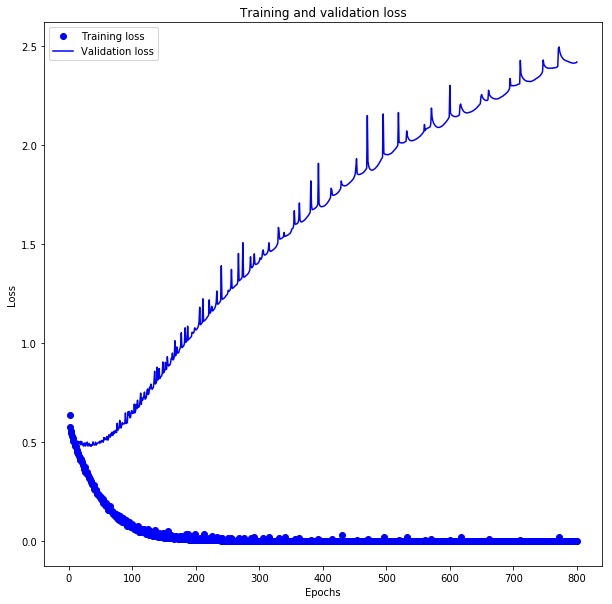

<Figure size 432x288 with 0 Axes>

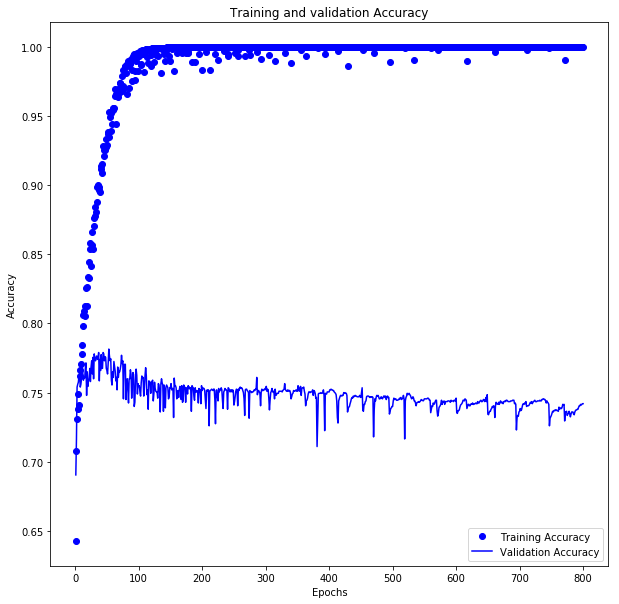

In [77]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.figure(figsize=(10,10))
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.figure(figsize=(10,10))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs = 50, batch_size = 512, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/50
7675/7675 [==============================] - 1s 152us/step - loss: 0.7379 - acc: 0.5347
Epoch 2/50
7675/7675 [==============================] - 1s 83us/step - loss: 0.6720 - acc: 0.5866
Epoch 3/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.6287 - acc: 0.6748
Epoch 4/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.5815 - acc: 0.7410
Epoch 5/50
7675/7675 [==============================] - 1s 85us/step - loss: 0.5127 - acc: 0.8044
Epoch 6/50
7675/7675 [==============================] - 1s 80us/step - loss: 0.4471 - acc: 0.8236
Epoch 7/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.3727 - acc: 0.8650
Epoch 8/50
7675/7675 [==============================] - 1s 82us/step - loss: 0.3509 - acc: 0.8782
Epoch 9/50
7675/7675 [==============================] - 1s 84us/step - loss: 0.3199 - acc: 0.8946
Epoch 10/50
7675/7675 [==============================] - 1s 81us/step - loss: 0.2976 - acc: 0.8984
Epoch 11/50
7675/7

[0.9689026575088501, 0.749]

Normalized confusion matrix


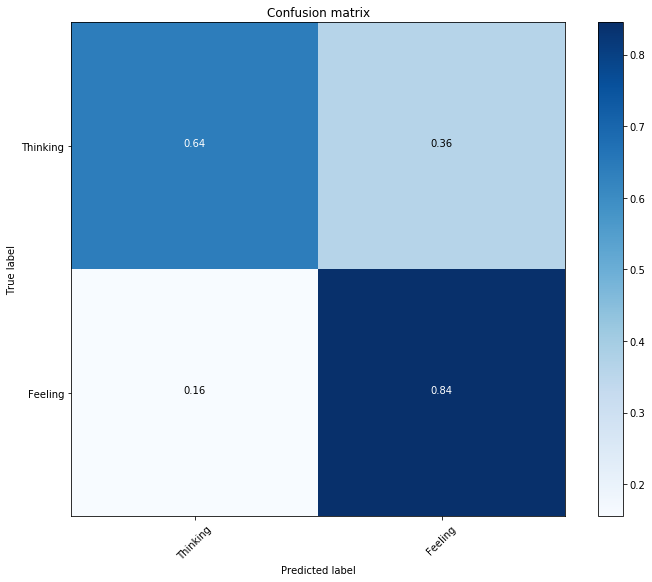

In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

#decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
#decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

decoded_y_true = y_test.round()
decoded_y_pred = y_pred.round()

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=[0, 1])
#matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
#matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
#matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
#matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(10,8))
plot_confusion_matrix(matrix, classes=["Thinking","Feeling"], normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

#plt.clf()
#plt.figure(figsize=(5,5))
#plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
#                      title='I-E Confusion matrix')
#name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
#plt.savefig(name)
#plt.show()
#pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
#                          title='N-S Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
#    plt.savefig(name)
#    plt.show()
#   pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
#                          title='T-F Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
#    plt.savefig(name)
#    plt.show()
#    pictures.append(name)

#    plt.clf()
#    plt.figure(figsize=(5,5))
#    plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
#                          title='J-P Confusion matrix')
#    name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
#    str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
#    plt.savefig(name)
#    plt.show()
#    pictures.append(name)